### ISCCP H-class dataset, global 1deg, 3hrly, lastest update 2017/06/28

- climatology of ISCCP cloud amount and cloud fraction catagorized by deep convection, shallow cumulus and stratus.<br>
- cloud types vs CWV

In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
warnings.filterwarnings('ignore')

In [3]:
ISCCP_dir = '/w2-data2/willytsai/ISCCP/hgg/'
TRMM_dir = '/w2-data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/w2-data2/willytsai/MERRA2/inst_2d_hourly/'
MERRA2_3d_dir = '/w2-data/willytsai/'
ERA5_dir = '/w2-data/willytsai/ERA5/'

In [4]:
%%time
# MERRA2 dataset 2014-2015, hourly in a single file
os.chdir(MERRA2_dir)
files = sorted(glob('MERRA2_400.inst1_2d_asm_Nx.2014*'))
              # + glob(MERRA2_dir+'MERRA2_400.inst1_2d_asm_Nx.2015*'))
data = xr.open_mfdataset(files)
data = data.resample(time='3H').nearest() # CWV
cwv_xr = data.TQV

CPU times: user 5.21 s, sys: 490 ms, total: 5.7 s
Wall time: 9.05 s


In [5]:
%%time 
os.chdir(ERA5_dir)
files = sorted(glob('*.nc'))
data = xr.open_mfdataset(files)
cwv_era_xr = data.tcwv

CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 14.7 ms


In [6]:
date = []; date_begin = datetime(2014,1,1)
for t in range(cwv_xr.shape[0]):
    tmp = date_begin + t*timedelta(hours=3)
    date.append(tmp)

In [7]:
%%time
# TRMM3B42 dataset 2014, 3hrly separate
yr = ['2014']
prec_3hr = np.nan*np.zeros((len(date),241,1440))

n=1
for y in yr:
    os.chdir(TRMM_dir+y)
    files = sorted(glob('3B42.*'))
    for file in files:
        data = xr.open_dataset(file).precipitation        
        prec_3hr[n-1,:,:] = data.values.swapaxes(0,1)
        n+=1
lon = data.nlon; lat = data.nlat
prec_xr = xr.DataArray(prec_3hr,coords=[date,lat,lon],dims=['time','lat','lon'])

CPU times: user 43 s, sys: 13.2 s, total: 56.3 s
Wall time: 1min 15s


In [8]:
%%time
# MERRA2 reanalysis 2014, 3hrly 

os.chdir(MERRA2_3d_dir+'2014_TQUV_3hr/')
files = sorted(glob('MERRA2_400.inst3*'))
              # + glob(MERRA2_dir+'MERRA2_400.inst1_2d_asm_Nx.2015*'))
data = xr.open_mfdataset(files)
T_xr = data.T   
q_xr = data.QV  
u_xr = data.U
v_xr = data.V

os.chdir(MERRA2_3d_dir+'2014_omega_3hr/')
files = sorted(glob('MERRA2_400.inst3*'))
              # + glob(MERRA2_dir+'MERRA2_400.inst1_2d_asm_Nx.2015*'))
data = xr.open_mfdataset(files)
Omega_xr = data.OMEGA

CPU times: user 9.96 s, sys: 164 ms, total: 10.1 s
Wall time: 11 s


In [9]:
# derive Relative hunidity
lev = T_xr.lev
es = 6.1094*np.exp(17.625*(T_xr-273)/(T_xr-273+243.04))
p = (q_xr/q_xr)*lev
qs = es/(p-es)*0.622
rh_xr = q_xr/qs*100 # relative humidity [%] 

In [10]:
%%time
cldamt_type_3hr = np.nan*np.zeros((len(date),18,180,360))
cldamt_3hr = np.nan*np.zeros((len(date),180,360))
# ISCCP dataset 2014, 3hourly in a single file
yr = ['2014'] # year
mn = ['01','02','03','04','05','06','07','08',
     '09','10','11','12'] # month

n=1
for y in yr:
    for m in mn:
        os.chdir(ISCCP_dir+y+m)
        files = sorted(glob('*.nc'))
        
        for file in files:
            data = xr.open_dataset(file).cldamt_types # cloud amount [%]
            data2 = xr.open_dataset(file).cldamt
            tmp = data; tmp2 = data2
            cldamt_type_3hr[n-1,:,:,:] = tmp
            cldamt_3hr[n-1,:,:] = tmp2
            n+=1
lat = tmp.lat; lon = tmp.lon
print(n-1)
cldamt_type_xr = xr.DataArray(cldamt_type_3hr,coords=[date,range(18),lat,lon],dims=['time','type','lat','lon']); del cldamt_type_3hr
cldamt_xr = xr.DataArray(cldamt_3hr,coords=[date,lat,lon],dims=['time','lat','lon']); del cldamt_3hr

2920
CPU times: user 1h 10min 43s, sys: 6min 22s, total: 1h 17min 5s
Wall time: 10min 44s


#### Cloud amounts for deep, shallow, status

In [11]:
lat = cldamt_type_xr.lat
lon = cldamt_type_xr.lon
# 0+3 shallow cumulus, 2+5 stratoform, 14+17 deep convection 
cldamt_cu = (cldamt_type_xr[:,0,:,:]+cldamt_type_xr[:,3,:,:]).values
cldamt_cu[cldamt_cu>500] = np.nan; cldamt_cu[cldamt_cu<-500] = np.nan;
cu_xr = xr.DataArray(cldamt_cu,coords=[date,lat,lon],dims=['time','lat','lon']); del cldamt_cu

cldamt_st = (cldamt_type_xr[:,13,:,:]+cldamt_type_xr[:,16,:,:]).values
cldamt_st[cldamt_st>500] = np.nan; cldamt_st[cldamt_st<-500] = np.nan;
st_xr = xr.DataArray(cldamt_st,coords=[date,lat,lon],dims=['time','lat','lon']); del cldamt_st

cldamt_dc = (cldamt_type_xr[:,14,:,:]+cldamt_type_xr[:,17,:,:]).values
cldamt_dc[cldamt_dc>500] = np.nan; cldamt_dc[cldamt_dc<-500] = np.nan;
dc_xr = xr.DataArray(cldamt_dc,coords=[date,lat,lon],dims=['time','lat','lon']); del cldamt_dc

#### Focusing on deep tropics 20N-20S
starting from climatology of cloud amount, connecting to TPW and Prec

In [12]:
dc_trop = dc_xr.sel(lat=slice(-20,20))
cu_trop = cu_xr.sel(lat=slice(-20,20))
st_trop = st_xr.sel(lat=slice(-20,20))

prec_trop = prec_xr.sel(lat=slice(-20,20))
cwv_trop = cwv_xr.sel(lat=slice(-20,20))

#### Cloud amounts for deep, shallow, status

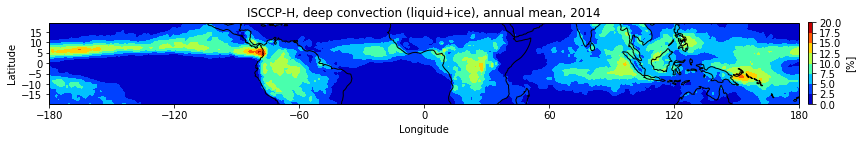

In [13]:
lon = dc_trop.lon
lat = dc_trop.lat

data, lon_plt = add_cyclic_point(np.nanmean(dc_trop,axis=0), coord=lon)

fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection=ccrs.PlateCarree(0))
ax.coastlines()
cm = ax.contourf(lon_plt,lat,data,transform=ccrs.PlateCarree(0),cmap='jet')
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree(0))
ax.set_yticks([-15, -10, -5, 0, 5,10,15], crs=ccrs.PlateCarree(0))
ax.set_xlabel('Longitude');ax.set_ylabel('Latitude')
ax.set_title('ISCCP-H, deep convection (liquid+ice), annual mean, 2014',fontsize=12)
cbar = plt.colorbar(cm,shrink=0.15,pad=0.01)
cbar.set_label('[%]',fontsize=10)

In [14]:
#fig_dir = '/w2-data2/willytsai/ISCCP/fig/'
#fig.savefig(fig_dir+'cldamt_DC_annualmean.pdf',dpi=200)

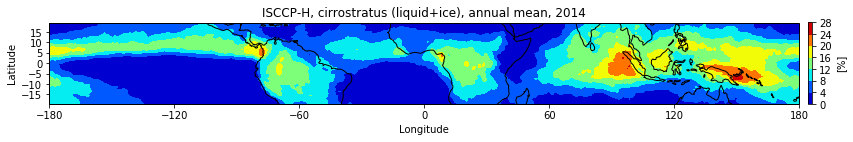

In [15]:
data, lon_plt = add_cyclic_point(np.nanmean(st_trop,axis=0), coord=lon)

fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection=ccrs.PlateCarree(0))
ax.coastlines()
cm = ax.contourf(lon_plt,lat,data,transform=ccrs.PlateCarree(0),cmap='jet')
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree(0))
ax.set_yticks([-15, -10, -5, 0, 5,10,15], crs=ccrs.PlateCarree(0))
ax.set_xlabel('Longitude');ax.set_ylabel('Latitude')
ax.set_title('ISCCP-H, cirrostratus (liquid+ice), annual mean, 2014',fontsize=12)
cbar = plt.colorbar(cm,shrink=0.15,pad=0.01)
cbar.set_label('[%]',fontsize=10)

In [16]:
#fig_dir = '/w2-data2/willytsai/ISCCP/fig/'
#fig.savefig(fig_dir+'cldamt_ST_annualmean.pdf',dpi=200)

#### 2 . statistical analysis over cloud types, CWV, prec
10x10 deg box over the Indian ocean (5S-5N, 65E-75E)

In [17]:
start_date = datetime(2014,6,1)
end_date = datetime(2014,8,30)
lat_s,lat_n = -5,5
lon_w,lon_e = 65,75

In [56]:
prec_sm = prec_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
cwv_sm = cwv_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
cwv_era_sm = cwv_era_xr.sel(latitude=slice(lat_n,lat_s),longitude=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
dc_sm = dc_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
cu_sm = cu_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
st_sm = st_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
cldamt_sm = cldamt_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))

T_sm = T_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
q_sm = q_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
u_sm = u_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
v_sm = v_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
omega_sm = Omega_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))
rh_sm = rh_xr.sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e),
                      time=slice(start_date,end_date))

Text(0.5, 1.0, 'Domain-averaged, INDO (5N-5S,65E-75E)')

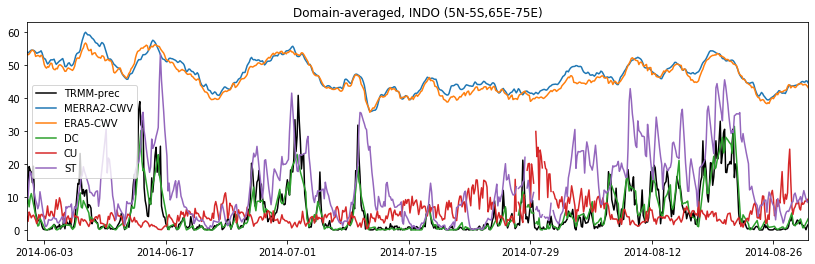

In [90]:
fig = plt.figure(figsize=(14,4))

ax = plt.subplot()
ax.plot(prec_sm.time,(prec_sm.mean(axis=1)*24).mean(axis=1),'k')
ax.plot(prec_sm.time,(cwv_sm.mean(axis=1)).mean(axis=1))
ax.plot(prec_sm.time,(cwv_era_sm.mean(axis=1)).mean(axis=1))
ax.plot(prec_sm.time,(dc_sm.mean(axis=1)).mean(axis=1))
ax.plot(prec_sm.time,(cu_sm.mean(axis=1)).mean(axis=1))
ax.plot(prec_sm.time,(st_sm.mean(axis=1)).mean(axis=1))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
ax.set_xlim([q_sm.time.values[0],q_sm.time.values[-1]])

plt.legend(['TRMM-prec','MERRA2-CWV','ERA5-CWV','DC','CU','ST'],fontsize=10)
plt.title('Domain-averaged, INDO (5N-5S,65E-75E)',fontsize=12)

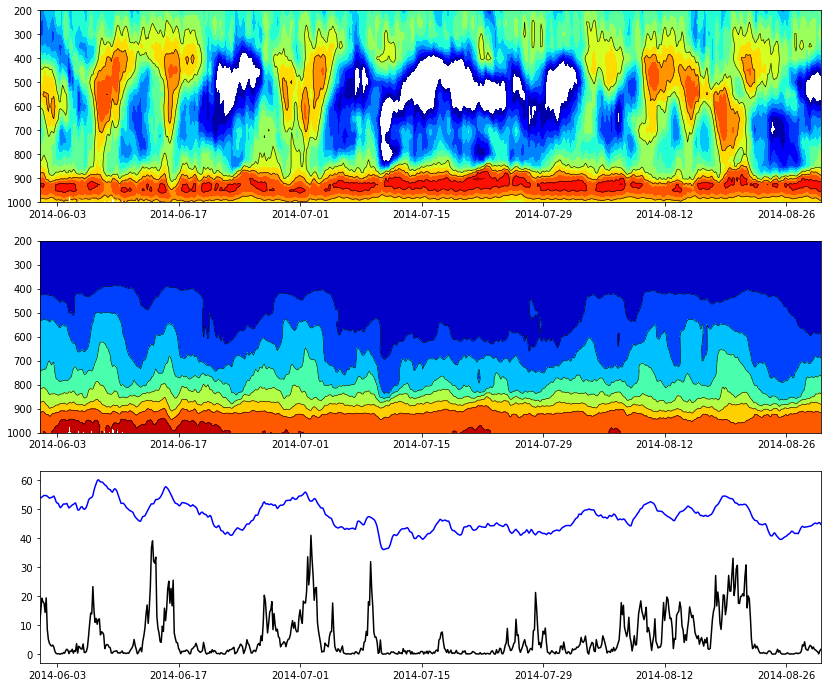

In [59]:
fig = plt.figure(figsize=(14,12))

ax1 = plt.subplot(3,1,1)
rh_dmean = (rh_sm.mean(axis=2)).mean(axis=2)
clev = np.linspace(30,100,15)
cf = ax1.contourf(q_sm.time.values,lev,rh_dmean.transpose(),levels=clev,cmap='jet')
ax1.contour(q_sm.time.values,lev,rh_dmean.transpose(),levels=['70','80','90'],colors=['k'],
          linewidths=0.6)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
ax1.set_ylim([1000,200])

ax2 = plt.subplot(3,1,2)
q_dmean = (q_sm.mean(axis=2)).mean(axis=2)
clev = np.linspace(30,100,15)
cf2 = ax2.contourf(q_sm.time.values,lev,q_dmean.transpose(),cmap='jet')
ax2.contour(q_sm.time.values,lev,q_dmean.transpose(),colors=['k'],
          linewidths=0.6)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax2.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
ax2.set_ylim([1000,200])

ax3 = plt.subplot(3,1,3)
ax3.plot(q_sm.time.values,(prec_sm.mean(axis=1)*24).mean(axis=1),'k')
ax3.plot(q_sm.time.values,cwv_sm.mean(axis=1).mean(axis=1),'b')
ax3.set_xlim([q_sm.time.values[0],q_sm.time.values[-1]])
ax3.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax3.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
#plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

(735385.0, 735475.0)

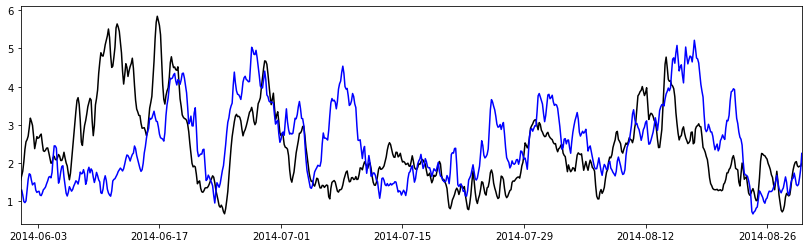

In [60]:
fig = plt.figure(figsize=(14,4))

llwsz_sm = np.abs(u_sm[:,6,:,:]-u_sm[:,1,:,:]) # low level zonal wind shear
llwsh_sm = np.abs(v_sm[:,6,:,:]-v_sm[:,1,:,:])

ax = plt.subplot()
ax.plot(q_sm.time,(llwsz_sm.mean(axis=1)).mean(axis=1),'k')
ax.plot(q_sm.time,(llwsh_sm.mean(axis=1)).mean(axis=1),'b')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
ax.set_xlim([q_sm.time.values[0],q_sm.time.values[-1]])

<a list of 8 text.Text objects>

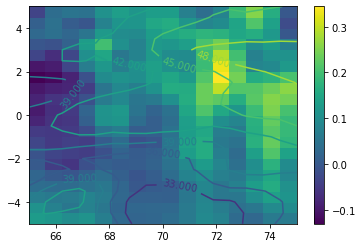

In [61]:
test = omega_sm.sel(time=datetime(2014,7,14,0),lev=slice(600,400))
tmp = test/test # ones matrix
omega_mid = np.trapz(test,test.lev*100,axis=0)/np.trapz(tmp,test.lev*100,axis=0)
test2 = cwv_sm.sel(time=datetime(2014,7,14,0))
plt.pcolor(omega_sm.lon,omega_sm.lat,omega_mid[:,:])
plt.colorbar()
cf = plt.contour(cwv_sm.lon,cwv_sm.lat,test2[:,:])
plt.clabel(cf)

In [62]:
#fig.savefig('/w2-data2/willytsai/ISCCP/fig/dmean_timeseries_WPC.png',dpi=200)

In [63]:
%%time
cwv_bin = np.linspace(35,60,26)
prec_bin = np.linspace(0,40,21)
cwv_dmean = cwv_sm.mean(axis=1).mean(axis=1)
prec_dmean = prec_sm.mean(axis=1).mean(axis=1)*24 # [mm/day]
dc_dmean = dc_sm.mean(axis=1).mean(axis=1)
cu_dmean = cu_sm.mean(axis=1).mean(axis=1)
st_dmean = st_sm.mean(axis=1).mean(axis=1)

cldamt_cwvbin = np.zeros((3,len(cwv_bin)-1))
cldamt_precbin = np.zeros((3,len(prec_bin)-1))

for i in range(len(cwv_bin)-1):
    idx = np.where(np.logical_and(cwv_dmean >= cwv_bin[i], cwv_dmean < cwv_bin[i+1]))[0]
    cldamt_cwvbin[0,i] = dc_dmean[idx].mean() # deep convection
    cldamt_cwvbin[1,i] = cu_dmean[idx].mean() # cumulus
    cldamt_cwvbin[2,i] = st_dmean[idx].mean() # cirrostratus

for i in range(len(prec_bin)-1):
    idx = np.where(np.logical_and(prec_dmean >= prec_bin[i], prec_dmean < prec_bin[i+1]))[0]
    cldamt_precbin[0,i] = dc_dmean[idx].mean() # deep convection
    cldamt_precbin[1,i] = cu_dmean[idx].mean() # cumulus
    cldamt_precbin[2,i] = st_dmean[idx].mean() # cirrostratus

CPU times: user 1min 54s, sys: 32.1 s, total: 2min 27s
Wall time: 2min 2s


Text(0.5, 1.0, 'Indian ocean (5S-5N, 65E-75E), 10x10 deg mean')

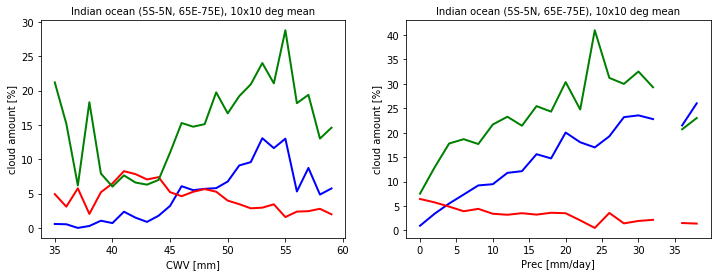

In [64]:
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(1,2,1)
ax1.plot(cwv_bin[:-1],cldamt_cwvbin[0,:],'b',linewidth=2)
ax1.plot(cwv_bin[:-1],cldamt_cwvbin[1,:],'r',linewidth=2)
ax1.plot(cwv_bin[:-1],cldamt_cwvbin[2,:],'g',linewidth=2)
ax1.set_ylabel('cloud amount [%]')
ax1.set_xlabel('CWV [mm]')
ax1.set_title('Indian ocean (5S-5N, 65E-75E), 10x10 deg mean',fontsize=10)

ax2 = plt.subplot(1,2,2)
ax2.plot(prec_bin[:-1],cldamt_precbin[0,:],'b',linewidth=2)
ax2.plot(prec_bin[:-1],cldamt_precbin[1,:],'r',linewidth=2)
ax2.plot(prec_bin[:-1],cldamt_precbin[2,:],'g',linewidth=2)
ax2.set_ylabel('cloud amount [%]')
ax2.set_xlabel('Prec [mm/day]')
ax2.set_title('Indian ocean (5S-5N, 65E-75E), 10x10 deg mean',fontsize=10)

In [65]:
#fig.savefig('/w2-data/willytsai/ISCCP/fig/cldamt_binned_WPC_JJA.png',dip=200)

#### 3. large-scale heat and moisture budget  v.s. cloud types

In [66]:
## Q1&Q2 apparent heat source/ moisture sink profile
Lv = 2.5*10**6; Rd = 287.15;Cp=1004
lev = T_sm.lev # pressure levels
z = 0*np.copy(T_sm.values)
for k in range(1,len(lev)):
    Tbar = T_sm[:,k-1:k+1,:,:].mean(axis=1)
    z[:,k,:,:] = z[:,k-1,:,:] + Rd*Tbar/9.8*np.log(lev[k-1]/lev[k])    

In [67]:
dqy = np.gradient(q_sm,50000,axis=2) # 1/m
dqx = np.gradient(q_sm,62500,axis=3) # 1/m
dqp = np.gradient(q_sm,lev*100,axis=1)
advq = u_sm*dqx + v_sm*dqy + omega_sm*dqp # 1/s
dqt = np.gradient(q_sm,3*3600,axis=0) # 1/s 
Q2 = -Lv*(dqt + advq)/Cp*86400 # [K/day]

dsy = np.gradient(Cp*T_sm+9.8*z,50000,axis=2) # 1/m
dsx = np.gradient(Cp*T_sm+9.8*z,62500,axis=3) # 1/m
dsp = np.gradient(Cp*T_sm+9.8*z,lev*100,axis=1)
advs = u_sm*dsx + v_sm*dsy + omega_sm*dsp # 1/s
dst = np.gradient(Cp*T_sm+9.8*z,3*3600,axis=0) # 1/s 

Q1 = (dst + advs)/Cp*86400 # [K/day]

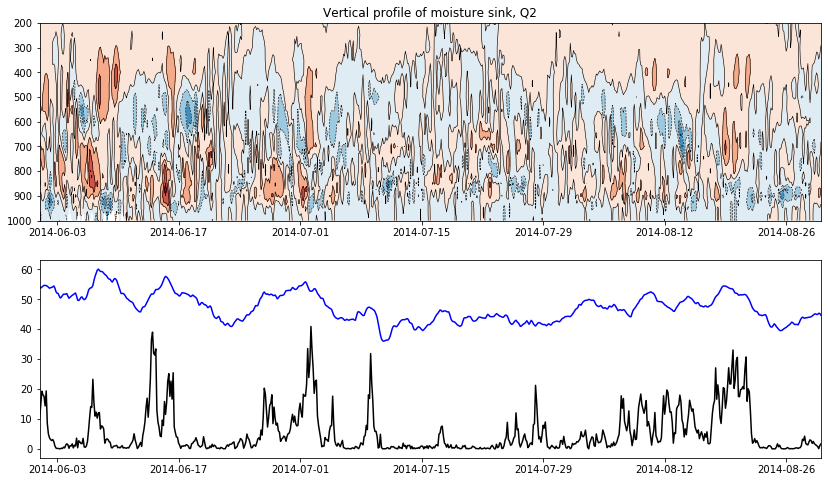

In [68]:
fig = plt.figure(figsize=(14,8))

Q2mean = np.mean(np.mean(Q2,axis=2),axis=2) # K/day

ax1 = plt.subplot(2,1,1)
cf = ax1.contourf(q_sm.time.values,lev,Q2mean.transpose(),levels=np.linspace(-20,20,9),
                  cmap='RdBu_r')
ax1.contour(q_sm.time.values,lev,Q2mean.transpose(),levels=np.linspace(-20,20,9)
            ,colors=['k'],linewidths=0.6)
#cbar = plt.colorbar(cf,shrink=0.5,pad=0.02)
#cbar.set_label('Q2 [K/day)]')
ax1.set_ylim([1000,200])
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
ax1.set_title('Vertical profile of moisture sink, Q2',fontsize=12)
#plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

ax2 = plt.subplot(2,1,2)
ax2.plot(q_sm.time.values,(prec_sm.mean(axis=1)*24).mean(axis=1),'k')
ax2.plot(q_sm.time.values,cwv_sm.mean(axis=1).mean(axis=1),'b')
ax2.set_xlim([q_sm.time.values[0],q_sm.time.values[-1]])
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax2.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
#plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [69]:
#fig.savefig('/w2-data/willytsai/ISCCP/fig/Q2timeseries_WPC_JJA.png',dip=200)

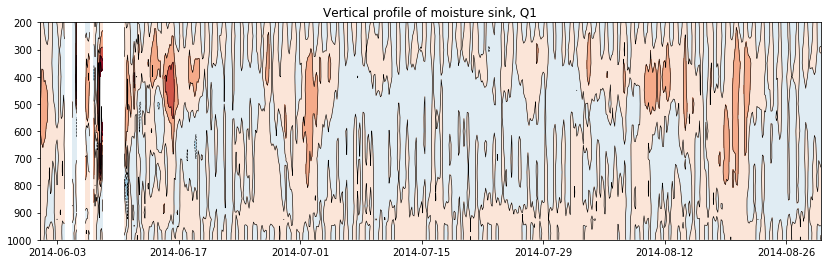

In [70]:
fig = plt.figure(figsize=(14,4))

Q1mean = np.nanmean(np.nanmean(Q1,axis=2),axis=2) # K/day
ax = plt.subplot()
cf = ax.contourf(T_sm.time.values,lev,Q1mean.transpose(),
             levels=np.linspace(-20,20,9),cmap='RdBu_r')
ax.contour(T_sm.time.values,lev,Q1mean.transpose(),
             levels=np.linspace(-20,20,9),colors=['k'],linewidths=0.6)
#cbar = plt.colorbar(cf,shrink=0.5,pad=0.02)
#cbar.set_label('Q1 [K/day)]')
ax.set_ylim([1000,200])
ax.set_title('Vertical profile of moisture sink, Q1',fontsize=12)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [71]:
#fig.savefig('/w2-data/willytsai/ISCCP/fig/Q1timeseries_WPC_JJA.png',dip=200)

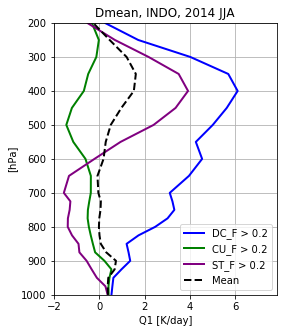

In [72]:
### Q1,Q2 profiles catagorized by cloud types
fig = plt.figure(figsize=(4,5))

dc_frac = (dc_sm/cldamt_sm).mean(axis=1).mean(axis=1)
cu_frac = (cu_sm/cldamt_sm).mean(axis=1).mean(axis=1)
st_frac = (st_sm/cldamt_sm).mean(axis=1).mean(axis=1)

idx1 = np.where(np.logical_and(dc_frac > 0.2,cu_frac < 0.1))[0]
idx2 = np.where(np.logical_and(cu_frac > 0.2,dc_frac+st_frac < 0.1))[0]
idx3 = np.where(np.logical_and(st_frac > 0.2,dc_frac+cu_frac < 0.1))[0]

Q1mean_dc = np.nanmean(Q1mean[idx1,:],axis=0)
Q1mean_cu = np.nanmean(Q1mean[idx2,:],axis=0)
Q1mean_st = np.nanmean(Q1mean[idx3,:],axis=0)

plt.plot(Q1mean_dc,lev,'b',linewidth=2)
plt.plot(Q1mean_cu,lev,'g',linewidth=2)
plt.plot(Q1mean_st,lev,'purple',linewidth=2)
plt.plot(np.nanmean(Q1mean,0),lev,'--k',linewidth=2)
plt.ylim([1000,200])
plt.xlabel('Q1 [K/day]');plt.ylabel('[hPa]')
plt.title('Dmean, INDO, 2014 JJA')
plt.legend(['DC_F > 0.2','CU_F > 0.2','ST_F > 0.2','Mean'])
plt.grid()

In [73]:
#fig.savefig('/w2-data/willytsai/ISCCP/fig/Q1vert_Ctypes_INDO_JJA.png',dip=200)

In [74]:
frac_bin = np.linspace(0,0.5,6)
Q1mean_dcfra = np.zeros((len(frac_bin)-1,len(lev)))
Q1mean_cufra = Q1mean_dcfra.copy()
Q1mean_stfra = Q1mean_dcfra.copy()

for i in range(len(frac_bin)-1):
    idx = np.where(np.logical_and(dc_frac > frac_bin[i], dc_frac < frac_bin[i+1]))[0]
    Q1mean_dcfra[i,:] = np.nanmean(Q1mean[idx,:],axis=0)
for i in range(len(frac_bin)-1):
    idx = np.where(np.logical_and(cu_frac > frac_bin[i], cu_frac < frac_bin[i+1]))[0]
    Q1mean_cufra[i,:] = np.nanmean(Q1mean[idx,:],axis=0)
for i in range(len(frac_bin)-1):
    idx = np.where(np.logical_and(st_frac > frac_bin[i], st_frac < frac_bin[i+1]))[0]
    Q1mean_stfra[i,:] = np.nanmean(Q1mean[idx,:],axis=0)

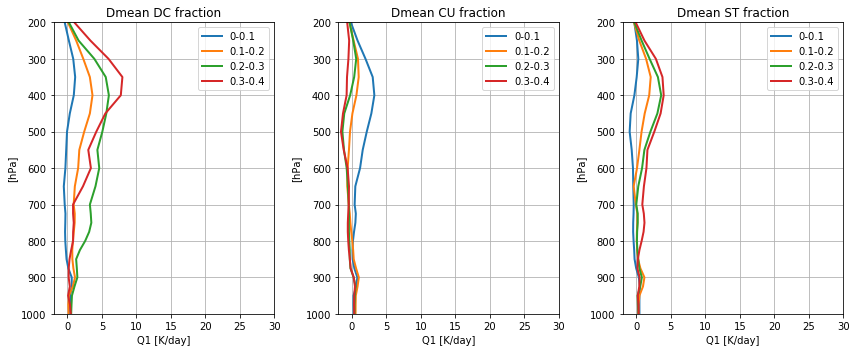

In [75]:
fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(1,3,1)
for i in range(Q1mean_dcfra.shape[0]-1):
    ax1.plot(Q1mean_dcfra[i,:],lev,linewidth=2)

ax1.legend(['0-0.1','0.1-0.2','0.2-0.3','0.3-0.4'])
ax1.set_ylabel('[hPa]');plt.xlabel('Q1 [K/day]')
ax1.set_title('Dmean DC fraction')
ax1.set_ylim([1000,200]);ax1.set_xlim([-2,30])
ax1.grid()

ax2 = plt.subplot(1,3,2)
for i in range(Q1mean_cufra.shape[0]-1):
    ax2.plot(Q1mean_cufra[i,:],lev,linewidth=2)

ax2.legend(['0-0.1','0.1-0.2','0.2-0.3','0.3-0.4'])
ax2.set_ylabel('[hPa]');plt.xlabel('Q1 [K/day]')
ax2.set_title('Dmean CU fraction')
ax2.set_ylim([1000,200]);ax2.set_xlim([-2,30])
ax2.grid()

ax3 = plt.subplot(1,3,3)
for i in range(Q1mean_stfra.shape[0]-1):
    ax3.plot(Q1mean_stfra[i,:],lev,linewidth=2)

ax3.legend(['0-0.1','0.1-0.2','0.2-0.3','0.3-0.4'])
ax3.set_ylabel('[hPa]');plt.xlabel('Q1 [K/day]')
ax3.set_title('Dmean ST fraction')
ax3.set_ylim([1000,200]);ax3.set_xlim([-2,30])
ax3.grid()

plt.tight_layout()

In [76]:
#fig.savefig('/w2-data/willytsai/ISCCP/fig/Q1vert_DCfrac_WPC_JJA.png',dip=200)

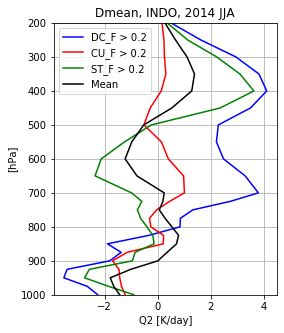

In [92]:
fig = plt.figure(figsize=(4,5))

dc_frac = (dc_sm/cldamt_sm).mean(axis=1).mean(axis=1)
cu_frac = (cu_sm/cldamt_sm).mean(axis=1).mean(axis=1)
st_frac = (st_sm/cldamt_sm).mean(axis=1).mean(axis=1)

idx1 = np.where(np.logical_and(dc_frac > 0.2,cu_frac < 0.1))[0]
idx2 = np.where(np.logical_and(cu_frac > 0.2,dc_frac+st_frac < 0.1))[0]
idx3 = np.where(np.logical_and(st_frac > 0.2,dc_frac+cu_frac < 0.1))[0]

Q2mean_dc = np.nanmean(Q2mean[idx1,:],axis=0)
Q2mean_cu = np.nanmean(Q2mean[idx2,:],axis=0)
Q2mean_st = np.nanmean(Q2mean[idx3,:],axis=0)

plt.plot(Q2mean_dc,lev,'b')
plt.plot(Q2mean_cu,lev,'r')
plt.plot(Q2mean_st,lev,'g')
plt.plot(np.mean(Q2mean,0),lev,'k')
plt.ylim([1000,200])
plt.xlabel('Q2 [K/day]');plt.ylabel('[hPa]')
plt.title('Dmean, INDO, 2014 JJA')
plt.legend(['DC_F > 0.2','CU_F > 0.2','ST_F > 0.2','Mean'])
plt.grid()

#### lag correlation among variables

In [78]:
def fft_filter(data,filtered_day,span_days):
    
    Vp = (data - data.mean()) # olr anomaly
    Vspec = np.fft.fft(Vp) 

    NT=len(data)
    freqs = np.array(range(NT))   # This gets the left end correct
    reversed_freqs = freqs[::-1]  # Reverse the array 
    reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
    freqs = reversed_freqs[::-1]  # reverse it back 
    
    # filtering and reconstructing data
    Vspec_filt = Vspec.copy()
    Vspec_filt[np.where(span_days/freqs < filtered_day)] = 0 # 60/freqs [day], filter out periods less than 2 day 
    Vp_recon = np.fft.ifft(Vspec_filt).real
    
    return Vp_recon

In [79]:
# fft for data
filtered_day = 1
span_days = 92

prec_dmean = (prec_sm.mean(axis=1)).mean(axis=1)
prec_filter = fft_filter(prec_dmean,filtered_day,span_days)

cwv_dmean = (cwv_sm.mean(axis=1)).mean(axis=1)
cwv_filter = fft_filter(cwv_dmean,filtered_day,span_days)

cwv_era_dmean = (cwv_era_sm.mean(axis=1)).mean(axis=1)
cwv_era_filter = fft_filter(cwv_era_dmean,filtered_day,span_days)

llwsz_dmean = (llwsz_sm.mean(axis=1)).mean(axis=1)
llwsz_filter = fft_filter(llwsz_dmean,filtered_day,span_days)

dc_dmean = (dc_sm.fillna(0).mean(axis=1)).mean(axis=1)
dc_filter = fft_filter(dc_dmean,filtered_day,span_days)

cu_dmean = (cu_sm.fillna(0).mean(axis=1)).mean(axis=1)
cu_filter = fft_filter(cu_dmean,filtered_day,span_days)

st_dmean = (st_sm.fillna(0).mean(axis=1)).mean(axis=1)
st_filter = fft_filter(st_dmean,filtered_day,span_days)

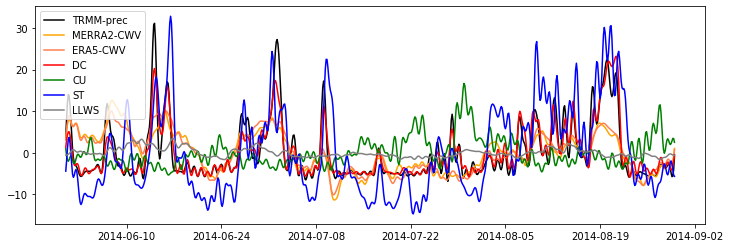

In [80]:
fig = plt.figure(figsize=(12,4))

ax = plt.subplot()
ax.plot(prec_dmean.time,prec_filter*24,'k')
ax.plot(cwv_dmean.time,cwv_filter,'orange')
ax.plot(cwv_era_dmean.time,cwv_era_filter,'coral')
ax.plot(prec_dmean.time,dc_filter,'r')
ax.plot(prec_dmean.time,cu_filter,'g')
ax.plot(prec_dmean.time,st_filter,'b')
ax.plot(llwsz_dmean.time,llwsz_filter,color='grey')
ax.legend(['TRMM-prec','MERRA2-CWV','ERA5-CWV','DC','CU','ST','LLWS']
          ,fontsize=10,loc=2)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

In [81]:
#fig.savefig('/w2-data/willytsai/ISCCP/fig/Allvars_timeseries_INDO_JJA.png',dip=200)

In [82]:
#lag correlation with prec
cwv_lagcoef = [np.corrcoef(prec_filter,np.roll(cwv_filter,-lag))[0,1] for lag in range(-40,40)]
cwv_era_lagcoef = [np.corrcoef(prec_filter,np.roll(cwv_era_filter,-lag))[0,1] for lag in range(-40,40)]
dc_lagcoef = [np.corrcoef(prec_filter,np.roll(dc_filter,-lag))[0,1] for lag in range(-40,40)]
cu_lagcoef = [np.corrcoef(prec_filter,np.roll(cu_filter,-lag))[0,1] for lag in range(-40,40)]
st_lagcoef = [np.corrcoef(prec_filter,np.roll(st_filter,-lag))[0,1] for lag in range(-40,40)]
llwsz_lagcoef = [np.corrcoef(llwsz_filter,np.roll(llwsz_filter,-lag))[0,1] for lag in range(-40,40)]

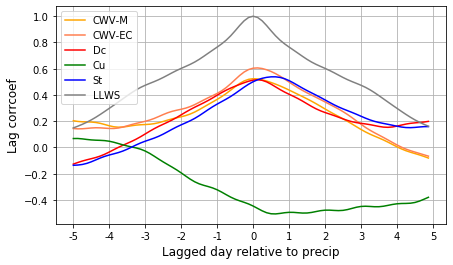

In [89]:
fig = plt.figure(figsize=(7,4))

plt.plot(range(-40,40),cwv_lagcoef,'orange')
plt.plot(range(-40,40),cwv_era_lagcoef,'coral')
plt.plot(range(-40,40),dc_lagcoef,'-r')
plt.plot(range(-40,40),cu_lagcoef,'-g')
plt.plot(range(-40,40),st_lagcoef,'-b')
plt.plot(range(-40,40),llwsz_lagcoef,'grey')
plt.xticks(ticks=np.linspace(-40,40,11,dtype=int)
           ,labels=np.linspace(-5,5,11,dtype=int))

plt.legend(['CWV-M','CWV-EC','Dc','Cu','St','LLWS'])
plt.ylabel('Lag corrcoef',fontsize=12)
plt.xlabel('Lagged day relative to precip',fontsize=12)
plt.grid()
plt.show()

fig.savefig('/w2-data/willytsai/ISCCP/fig/Allvars_lagged_INDO_JJA.png',dip=300)

In [84]:
#lag correlation with prec
dc_lagcoef = [np.corrcoef(cwv_filter,np.roll(dc_filter,-lag))[0,1] for lag in range(-40,40)]
cu_lagcoef = [np.corrcoef(cwv_filter,np.roll(cu_filter,-lag))[0,1] for lag in range(-40,40)]
st_lagcoef = [np.corrcoef(cwv_filter,np.roll(st_filter,-lag))[0,1] for lag in range(-40,40)]

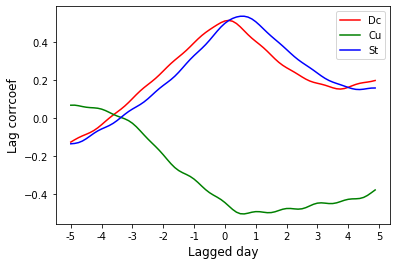

In [85]:
plt.plot(range(-40,40),dc_lagcoef,'-r')
plt.plot(range(-40,40),cu_lagcoef,'-g')
plt.plot(range(-40,40),st_lagcoef,'-b')
plt.xticks(ticks=np.linspace(-40,40,11,dtype=int)
           ,labels=np.linspace(-5,5,11,dtype=int))

plt.legend(['Dc','Cu','St'])
plt.ylabel('Lag corrcoef',fontsize=12)
plt.xlabel('Lagged day',fontsize=12)
plt.show()

### 3. spatial variations of < h >', cwv, precip with time

In [ ]:
h = Cp*T_sm + 9.8*z + Lv*q_sm# dry static energy
tmp = h/h
MSE_vavg = (np.trapz(h[:,:24,:,:],-lev[:24]*100,axis=1)
           /np.trapz(tmp[:,:24,:,:],-lev[:24]*100,axis=1)/1000) # column-averaged to 100hpa

In [ ]:
fig = plt.figure(figsize=(12,6))

VMSE_std = np.nanstd(MSE_vavg.reshape(MSE_vavg.shape[0],MSE_vavg.shape[1]*MSE_vavg.shape[2]),axis=1)
cwv_std = np.nanstd(cwv_sm.values.reshape(cwv_sm.shape[0],cwv_sm.shape[1]*cwv_sm.shape[2]),axis=1)

ax1 = plt.subplot(3,1,1)
ax1.plot(h.time,VMSE_std)

ax2 = plt.subplot(3,1,2)
ax2.plot(prec_dmean.time,prec_dmean)

ax3 = plt.subplot(3,1,3)
ax3.plot(prec_dmean.time,cwv_std)

In [ ]:
plt.pcolor(cwv_sm.lon,cwv_sm.lat,cwv_sm.sel(time=datetime(2014,7,1)))
plt.colorbar()
plt.contour(prec_sm.lon,prec_sm.lat,prec_sm.sel(time=datetime(2014,7,1)))

In [ ]:
# red noise test
#w_noise = np.random.standard_normal(len(prec_filter))
#r_noise